## Computational Bayes Final Project
Nathan Yee  
Uma Desai  

To understand Bayesian Linear Regression, we read through and used many ideas from Cypress Frankenfeld. http://allendowney.blogspot.com/2015/04/two-hour-marathon-by-2041-probably.html

## Height of Children in Kalama, Egypt
From: http://lib.stat.cmu.edu/DASL/Datafiles/Ageandheight.html
> The height of a child is not stable but increases over time. Since the pattern of growth varies from child to child, one way to understand the general growth pattern is by using the average of several children's heights, as presented in this data set. The scatterplot of height versus age is almost a straight line, showing a linear growth pattern. The straightforward relationship between height and age provides a simple illustration of linear relationships, correlation, and simple regression. 

>Description: Mean heights of a group of children in Kalama, an Egyptian village that is the site of a study of nutrition in developing countries. The data were obtained by measuring the heights of all 161 children in the village each month over several years. 

>Age: Age in months

>Height: Mean height in centimeters for children at this age 

#### What is the probability that a child between the ages of 18 - 29 is less than 76.1 cm (the lowest height in our dataset)?

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf
import thinkplot
import pandas as pd
import matplotlib.pyplot as plt

Let's start by loading our data into a Pandas dataframe to see what we're working with.

In [2]:
df = pd.read_csv('ageVsHeight.csv', skiprows=0, delimiter='\t')
df

,age,height
0,18,76.1
1,19,77.0
2,20,78.1
3,21,78.2
4,22,78.8
5,23,79.7
6,24,79.9
7,25,81.1
8,26,81.2
9,27,81.8


Next, let's create vectors of our ages and heights.

In [3]:
ages = np.array(df['age'])
heights = np.array(df['height'])

Now let's visualize our data to make sure that linear regression is appropriate for predicting its distributions.

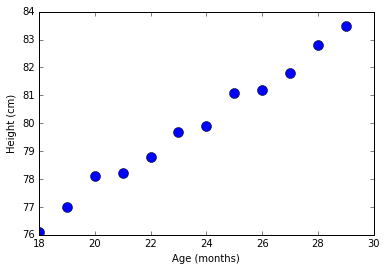

In [4]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.xlabel('Age (months)')
plt.ylabel('Height (cm)')

Our data looks pretty linear. We can now calculate the slope and intercept of the line of least squares. We abstract numpy's least squares function using a function of our own.

In [5]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

To use our leastSquares function, we input our age and height vectors as our x and y arguments. Next, let's call leastSquares to get the slope and intercept, and use the slope and intercept to calculate the size of our intercept and slope ranges.

In [6]:
slope, intercept = leastSquares(ages, heights)
print(slope, intercept)
intercept_range = .03 * intercept
slope_range = .05 * slope

0.634965034965 64.9283216783


Now, we can visualize the slope and intercept on the same plot as the data to make sure it is working correctly.

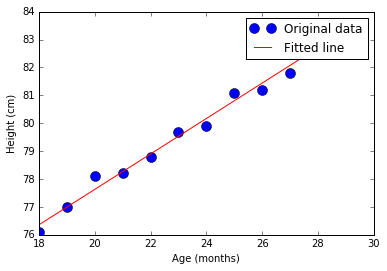

In [7]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
plt.legend()
plt.xlabel('Age (months)')
plt.ylabel('Height (cm)')
plt.show()

Looks great! Based on the plot above, we are confident that Bayesian linear regression will give us reasonable distributions for predicting future values. Now we need to create our hypotheses. Each hypothesis will consist of a range of intercepts, slopes and sigmas.

In [8]:
intercepts = np.linspace(intercept - intercept_range, intercept + intercept_range, 20)
slopes = np.linspace(slope - slope_range, slope + slope_range, 20)
sigmas = np.linspace(2, 4, 15)

hypos = ((intercept, slope, sigma) for intercept in intercepts 
         for slope in slopes for sigma in sigmas)

Loop through ages and heights to create tuples as data for our hypotheses.

In [9]:
data = [(age, height) for age in ages for height in heights]

Next make a least squares class that inherits from Suite and Joint where likelihood is calculated based on error from data. The likelihood function will depend on the data and normal distributions for each hypothesis.

In [10]:
class leastSquaresHypos(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (ages Vs height) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for age, measured_height in data:
            hypothesized_height = slope * age + intercept
            error = measured_height - hypothesized_height
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood
        

Now instantiate a LeastSquaresHypos suite with our hypos.

In [11]:
LeastSquaresHypos = leastSquaresHypos(hypos)

And update the suite with our data. We choose to update a single item at a time to normalize after every item in data.

In [12]:
for item in data:
    LeastSquaresHypos.Update([item])

We can now plot marginal distributions to visualize the probability distribution for each of our hypotheses for intercept, slope, and sigma values. Our hypotheses were carefully picked based on ranges that we found worked well, which is why all the intercepts, slopes, and sigmas that are important to this dataset are included in our hypotheses.

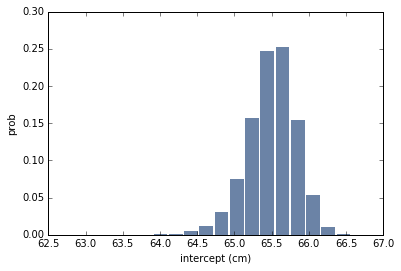

In [13]:
marginal_intercepts = LeastSquaresHypos.Marginal(0)
thinkplot.hist(marginal_intercepts)
thinkplot.Config(xlabel='intercept (cm)', ylabel='prob')

Since our slopes are relatively close to our original slope, we are relatively confdient that these produce reasonable distributions even though it does get cut off.

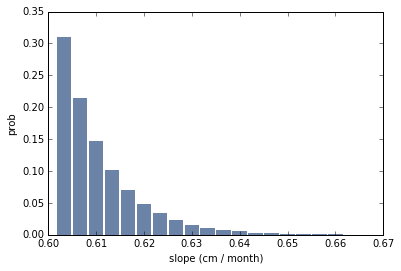

In [14]:
marginal_slopes = LeastSquaresHypos.Marginal(1)
thinkplot.hist(marginal_slopes)
thinkplot.Config(xlabel='slope (cm / month)', ylabel='prob')

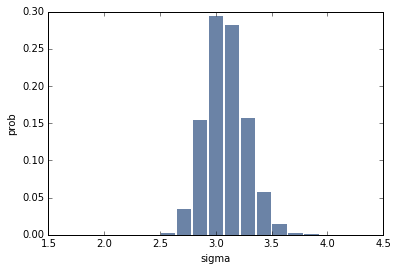

In [15]:
marginal_sigmas = LeastSquaresHypos.Marginal(2)
thinkplot.hist(marginal_sigmas)
thinkplot.Config(xlabel='sigma', ylabel='prob')

Next, we want to sample random data from our hypotheses. To do this, we will make two functions, getHeights and getRandomData. getRandomData calls getHeights to obtain random height values.

In [16]:
def getHeights(hypo_samples, random_months):
    """
    getHeights takes in random hypos and random months and returns the coorisponding
    random height
    
    Args:
        hypo_samples (sequence): Sampled hypotheses from the LeastSquaredHypos suite
        random_months (sequence): Randomly sampled months
    """
    random_heights = np.zeros(len(random_months))
    for i in range(len(random_heights)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_months[i]
        random_heights[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_heights

def getRandomData(start_month, end_month, n, LeastSquaresHypos):
    """
    getRadomData computes and returns two sequences
    
    Args:
        start_month: (number): Starting month
        end_month: (number): Ending month
        n (int): Number of samples
        LeastSquaresHypos (Suite): Contains the hypos we want to sample
    
    Returns:
        Sequence of random_months and random_heights
    
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_months = np.random.uniform(start_month, end_month, n)
    random_heights = getHeights(random_hypos, random_months)
    return random_months, random_heights

Now we take 10000 random samples of pairs of months and heights. Here we want at least 10000 items so that we can get very smooth sampling.

In [17]:
num_samples = 100000
random_months, random_heights = getRandomData(18, 29, num_samples, LeastSquaresHypos)

Now plot the data to see what the randomly sampled data looks like beneath the original data and line of least squares. We notice that we have trouble seeing the exact size of our distribution as points overlap each other. To see what the distribution actually looks like, we must make a density plot.

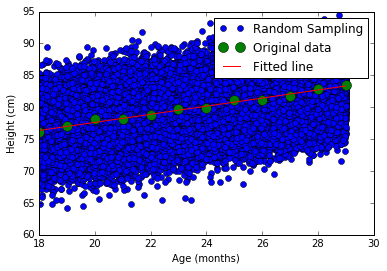

In [18]:
plt.plot(random_months, random_heights, 'o', label='Random Sampling')
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
plt.xlabel('Age (months)')
plt.ylabel('Height (cm)')
plt.legend()
plt.show()

Next, we want to get the intensity of the data at locations. We do that by adding the randomly sampled values to buckets. This gives us intensity values for a grid of pixels in our sample range.

In [19]:
num_buckets = 70 # num_buckets^2 is actual number

# create horizontal and vertical linearly spaced ranges as buckets.
hori_range, hori_step = np.linspace(18, 29 , num_buckets, retstep=True)
vert_range, vert_step = np.linspace(65, 100, num_buckets, retstep=True)

hori_step = hori_step / 2
vert_step = vert_step / 2

# store each bucket as a tuple in a the buckets dictionary.
buckets = dict()
keys = [(hori, vert) for hori in hori_range for vert in vert_range]

# set each bucket as empty
for key in keys:
    buckets[key] = 0
    
# loop through the randomly sampled data
for month, height in zip(random_months, random_heights):
    # check each bucket and see if randomly sampled data 
    for key in buckets:
        if month > key[0] - hori_step and month < key[0] + hori_step:
            if height > key[1] - vert_step and height < key[1] + vert_step:
                buckets[key] += 1
                break # can only fit in a single bucket

Next, we unpack the buckets into three vectors, pcolor_months, pcolor_heights, and pcolor_densities

In [20]:
pcolor_months = []
pcolor_heights = []
pcolor_densities = []
for key in buckets:
    pcolor_months.append(key[0])
    pcolor_heights.append(key[1])
    pcolor_densities.append(buckets[key])

Since density plotting is much simpler in Mathematica, we are going to export all our data to csv files and plot them in Mathematica

In [21]:
def append_to_file(path, data):
    """
    append_to_file appends a line of data to specified file.  Then adds new line
    
    Args:
        path (string): the file path
    
    Return:
        VOID
    """
    with open(path, 'a') as file:
        file.write(data + '\n')
        
def delete_file_contents(path):
    """
    delete_file_contents deletes the contents of a file
    
    Args:
        path: (string): the file path
        
    Return:
        VOID
    """
    with open(path, 'w'):
        pass

def threeSequenceCSV(x, y, z):
    """
    Writes the x, y, z arrays to a CSV
    
    Args:
        x (sequence): x data
        y (sequence): y data
        z (sequence): z data    
    """
    file_name = 'intensityData.csv'
    delete_file_contents(file_name)

    for xi, yi, zi in zip(x, y, z):
        append_to_file(file_name, "{}, {}, {}".format(xi, yi, zi))
        
def twoSequenceCSV(x, y):
    """
    Writes the x, y arrays to a CSV
    
    Args:
        x (sequence): x data
        y (sequence): y data
    """
    file_name = 'monthsHeights.csv'
    delete_file_contents(file_name)
    
    for xi, yi in zip(x, y):
        append_to_file(file_name, "{}, {}".format(xi, yi))
        
def fittedLineCSV(x, slope, intercept):
    """
    Writes line data to a CSV
    
    Args:
        x (sequence): x data
        slope (float): slope of line
        intercept (float): intercept of line
    """
    file_name = 'fittedLineCSV.csv'
    delete_file_contents(file_name)
    for xi in x:
        append_to_file(file_name, "{}, {}".format(xi, slope*xi + intercept))
        
def makeCSVData(random_x, random_y, intensities, original_x, original_y, slope, intercept):
    """
    Calls the 3 csv making functions with appropriate parameters.
    """
    threeSequenceCSV(random_x, random_y, intensities)
    twoSequenceCSV(original_x, original_y)
    fittedLineCSV(original_x, slope, intercept)

In [22]:
makeCSVData(pcolor_months, pcolor_heights, pcolor_densities, ages, heights, slope, intercept)

Now, we have a figure that contains superimposed density plot, original data scatter plot, and least squares line plot. While the density plot is not strictly necessary, it gives us a much better idea as to how large of a distribution we have. Note that the x axis is ages (months) and the y axis is height (cm).

<img src="ageHeightAllPlots5.png" alt="Density Plot with orignal data/fit" height="400" width="400">

So, now we can go back to our original question. What is the probability that a child between the ages of 18 - 29 is less than 76.1 cm (the lowest height in our dataset)? To answer this question, we sample our random data and see whether or not it is less than 76.1 cm. We will do this using a function.

In [23]:
def probHeightRange(heights, low, high):
    """
    probHeightRange returns the probability that height is within a particular range
    
    Args:
        height (sequence): sequence of heights
        low (number): the bottom of the range
        high (number): the top of the range
        
    Returns:
        prob (float): the probability of being in the height range
    """
    successes = 0
    total = len(heights)
    for height in heights:
        if low < height and height < high:
            successes += 1
    
    return successes / total
    

In [24]:
probHeightRange(random_heights, 0, 76.1)

0.15385

We find that 15.55 % of children in Kalama, Egypt between the ages of 18 - 29 months are less than 76.1 cm (the lowest height in our dataset)